# Train RNN with data extracted from DNA containing the TATA Box sequence
(Example from: Property Checking with Interpretable Error Characterization)

In [1]:
cd ..

c:\Users\franz\Repos\pyModelExtractor_use_cases


In [14]:
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner
from pythautomata.model_exporters.partition_mapper import TopKPartitionMapper
from pythautomata.model_exporters.wfa_image_exporter_with_partition_mapper import WFAImageExporterWithPartitionMapper
from pythautomata.base_types.symbol import SymbolStr

from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pymodelextractor.teachers.pac_batch_probabilistic_teacher import PACBatchProbabilisticTeacher

from utilities.neural_networks.model_definitions import Models 
from data.data_loaders.tata_box_data_loader import TataBoxDataLoader
from utilities.neural_networks.neural_nets_train_auxiliar import load_data_and_train_last_token_language_model_network
from  tensorflow.keras.optimizers import Adam
from IPython.display import Image
from utilities.neural_networks.rnn_language_models.last_token_language_model import LastTokenLanguageModel

### Get DataLoader 

In [3]:
dataloader = TataBoxDataLoader("./data/tata_box/")
alphabet = dataloader.alphabet

### Select network architecture from predefined ones 

In [4]:
has_embedding = False
input_vocab_size = len(alphabet) + 1  #to consider padding symbol
output_vocab_size = len(alphabet) + 1 #to consider terminal symbol
keras_network_architecture = Models.last_token_lstm_model(input_vocab_size, output_vocab_size, has_embedding)

### Define data generation and training parametters

In [5]:
max_sequence_length_for_training = 6
generated_training_data_size = 10000
window_size = 3
output_path="neural_networks/trained_models/tata_box_last_token_language_model/"
padding_symbol= SymbolStr('0')
terminal_symbol= SymbolStr('$')
training_params = {'patience':10, 'epochs':50, 'batch_size':100, 'learning_rate':0.01, 'criterion':Adam, 'loss':'categorical_crossentropy'}
seed = 28

### Generate data and Train
(These abstractions are made for the sake of simplicity, any model and architecture is valid, as long as it implements the ProbabilisticModel interface)

In [6]:
already_trained = True
if already_trained:
    model = LastTokenLanguageModel(output_path)
else:
    model, eval = load_data_and_train_last_token_language_model_network(dataloader, output_path, window_size, padding_symbol, terminal_symbol, keras_network_architecture, training_params, seed, not has_embedding)

The model has been successfully loaded


In [15]:
model._model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          16896     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 lstm_1 (LSTM)               (None, 62)                23064     
                                                                 
 dense_1 (Dense)             (None, 5)                 315       
                                                                 
Total params: 42,225
Trainable params: 42,225
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras.utils import plot_model

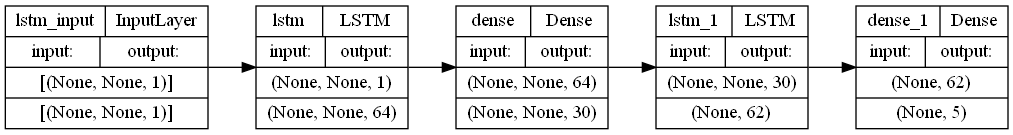

In [21]:
plot_model(model._model, rankdir="LR",show_shapes =True)

### Define Probability Partitioner
(The ArgMaxProbabilityPartitioner considers two probabilities to be equivalent if their arg max is)

In [7]:
partitioner = TopKProbabilityPartitioner(1)

### Define a Learner, a Comparator, and a Teacher

In [8]:
comparator = WFAPartitionComparator(partitioner)

learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states = 20, max_query_length = 100, max_seconds_run=None, generate_partial_hipothesis = True, check_probabilistic_hipothesis=False)

teacher  = PACBatchProbabilisticTeacher(model, epsilon = 0.05, delta = 0.05, max_seq_length = 20, comparator = comparator)

### Run extraction

In [9]:
extracted_model = learner.learn(teacher, verbose = True).model

Size before update: 3
CE: TTGTC
----update_node----
Old Node (new Leaf) TTGTC
New Leaf TT
dict_keys([TTGTC, ϵ, A])
dict_keys([TTGTC, ϵ, A, TT])
--------
Size after update: 5
Size before update: 5
CE: TTGTC
----update_node----
Old Node (new Leaf) TT
New Leaf TTGT
dict_keys([TTGTC, ϵ, A, TT, TTGTCT])
dict_keys([TTGTC, ϵ, A, TT, TTGTCT, TTGT])
--------
Size after update: 7
Size before update: 7
CE: GTTCCATCACCAATTCG
----update_node----
Old Node (new Leaf) TTGTCT
New Leaf G
dict_keys([TTGTC, ϵ, A, TT, TTGTCT, TTGT, C])
dict_keys([TTGTC, ϵ, A, TT, TTGTCT, TTGT, C, G])
--------
Size after update: 8
Size before update: 8
CE: GTTCCATCACCAATTCG
----update_node----
Old Node (new Leaf) TTGTCT
New Leaf GT
dict_keys([TTGTC, ϵ, A, TT, TTGTCT, TTGT, C, G])
dict_keys([TTGTC, ϵ, A, TT, TTGTCT, TTGT, C, G, GT])
--------
Size after update: 9
Size before update: 9
CE: GTTCCATCACCAATTCG
----update_node----
Old Node (new Leaf) ϵ
New Leaf GTTC
dict_keys([TTGTC, ϵ, A, TT, TTGTCT, TTGT, C, G, GT])
dict_keys([T

In [10]:
path = 'learning_outputs/'
mapped_name = extracted_model.name+"_partitioned_top_1"
WFAImageExporterWithPartitionMapper(TopKProbabilityPartitioner(
            1), TopKPartitionMapper()).export(extracted_model, path, mapped_name)


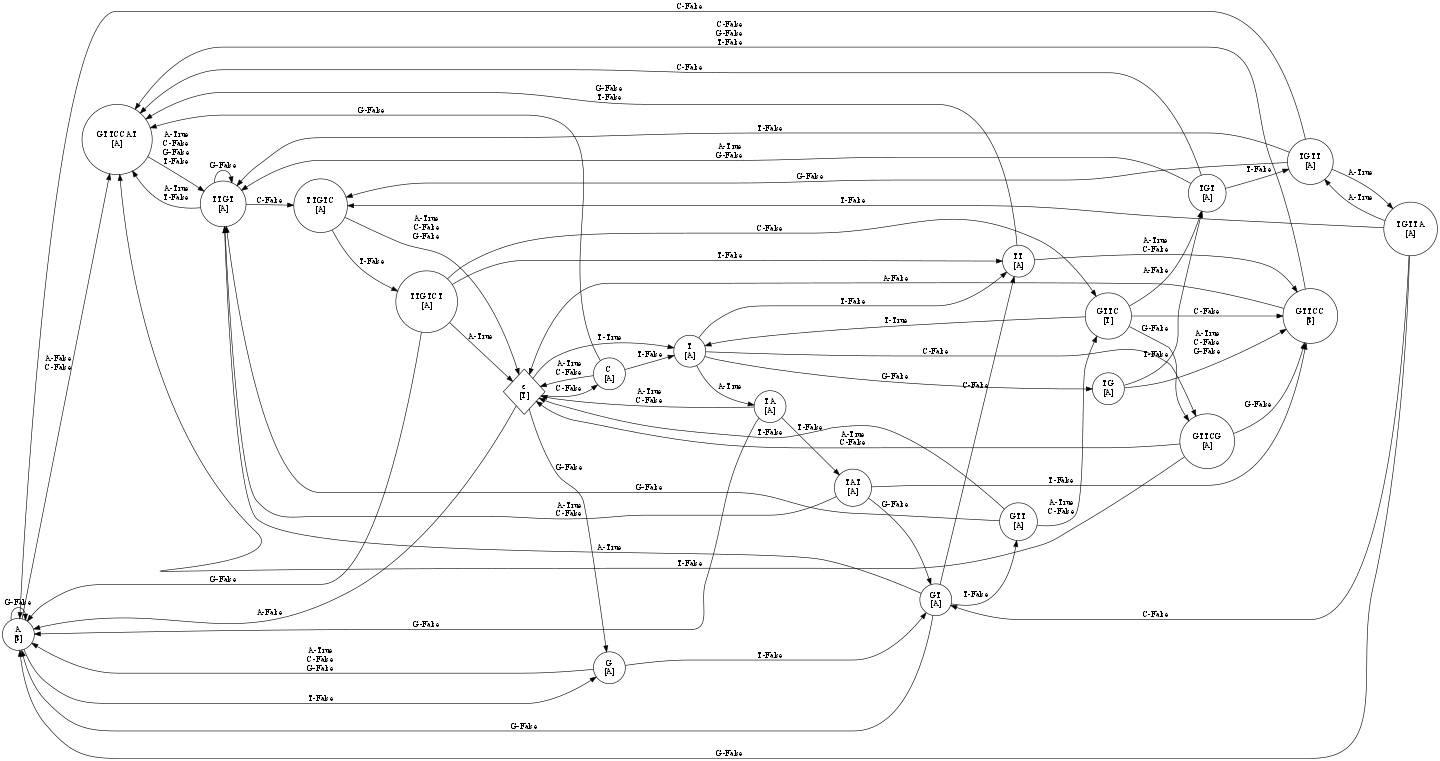

In [11]:
Image(path+mapped_name+'.png')

In [ ]:
extracted_model.export(path)
Image(path+extracted_model.name+'.png')

In [ ]:
for state in extracted_model.weighted_states:
    print(state.transitions_set)